### Minimum Set Cover

In [1]:
import json
import pandas as pd
from collections import Counter
from numpy import array, eye, hstack, ones, vstack, zeros
import cvxopt
from cvxopt.glpk import ilp
import time
from itertools import chain
from Graph_Helpers import *
from MinSetCover import Min_cover_set, Min_cover_set_greedy
import matplotlib.pyplot as plt
import math

## Loading matching spices and their mitigating diseases

In [2]:
import json

# Load the cuisine_spicehnd_dict_combined.json file
with open(('Derived_Data/Overlap/cuisine_spicehnd_dict_combined.json'), 'r') as file:
    cuisine_spice_dict = json.load(file)

# Load the spice2indic_phytononzero.json file
with open(('Derived_Data/Spice2Phytochemical2Disease/spice2indic_phytononzero.json'), 'r') as file:
    spice2indic_dict = json.load(file)

# Create a set of all spices present in cuisine_spicehnd_dict_combined.json
cuisine_spices = set()
for dish, spices in cuisine_spice_dict.items():
    cuisine_spices.update(spices)

# Create a new dictionary to store the matching spices and their disorders
matching_spices = {}

# Iterate over each spice in spice2indic_phytononzero.json
for spice, disorders in spice2indic_dict.items():
    # Check if the spice is present in cuisine_spicehnd_dict_combined.json
    if spice.lower() in cuisine_spices:
        matching_spices[spice] = disorders

# Save the matching spices and their disorders to a new JSON file
with open('matching_spices.json', 'w') as file:
    json.dump(matching_spices, file, indent=4)

print("Matching spices and their disorders saved to 'matching_spices.json'.")

Matching spices and their disorders saved to 'matching_spices.json'.


## Preprocessing of indic2group xlsx

In [3]:
label_file = 'Derived_Data/MinSetCover/indic_all_categorized_malacards_LRV.xlsx'
result_folder = 'Derived_Data/MinSetCover/'
plot_folder = result_folder + 'minset_plots/'
spice2indic = json2dict('matching_spices.json')
indic2spice = reverse_dict(spice2indic)
label_df = pd.read_excel(label_file)

group2indic2spice = {}
for indic in indic2spice.keys():
    icd_category = label_df[label_df.hnd_indic == indic]['ICD Category']
    if not icd_category.empty:
        group = list(icd_category)[0]
        if str(group) == 'nan':
            group = 'General symptom'
        if group not in group2indic2spice:
            group2indic2spice[group] = {}
        group2indic2spice[group].update({indic: indic2spice[indic]})

dict2json(group2indic2spice, result_folder + 'group2indic2spice.json')

## check which disease category disorder 'x' belongs to

In [6]:
group_list = []
for group, indic2spice in group2indic2spice.items():
    if indic2spice:
        group_list.append(group)
    for indic in indic2spice.keys():
        if indic == 'Nervousness':
            print(group)

mental_disease


In [7]:
print(group_list)

['mental_disease', 'musculoskeletal_disease ', 'gastrointestinal_disease', 'neuronal_disease', 'infectious_disease', 'respiratory_disease', 'General symptom', 'cancer_disease', 'cardiovascular_disease', 'nephrological_disease', 'eye_disease', 'poisoning', 'blood_disease', 'injury', 'skin_disease', 'endocrine_disease', 'reproductive_disease', 'ear_disease', 'metabolic_disease', 'immune_disease', 'sleep_disease', 'pregnancy_disease', 'general_disease', 'nutritional_disease', 'oral_disease', 'othercauses', 'smell_taste_disease']


In [8]:
group2indic2spice.keys()

dict_keys(['mental_disease', 'musculoskeletal_disease ', 'gastrointestinal_disease', 'neuronal_disease', 'infectious_disease', 'respiratory_disease', 'General symptom', 'cancer_disease', 'cardiovascular_disease', 'nephrological_disease', 'eye_disease', 'poisoning', 'blood_disease', 'injury', 'skin_disease', 'endocrine_disease', 'reproductive_disease', 'ear_disease', 'metabolic_disease', 'immune_disease', 'sleep_disease', 'pregnancy_disease', 'general_disease', 'nutritional_disease', 'oral_disease', 'othercauses', 'smell_taste_disease'])

## Generate Min Set Cover for each disease group

In [9]:

disease_groups = list(group2indic2spice.keys())
results_pd = pd.DataFrame(index = disease_groups, columns= ['#Spices', '#Indications', 'Min number of spices to cover indications', 'Min set'])

indic2spice_adjmtx = []
for group in disease_groups:
    set_name = ['Spices', 'Indications']
    spice2indic_onegroup = reverse_dict(group2indic2spice[group])
    bi_graph, spice_topset, indic_botset = Bipartite_graph(spice2indic_onegroup, set_name)
    # row: bottom nodes - dict.values; column: top nodes - dict.keys - indicationsbot
    # top_set: indic; bot_set: spices
    adjmtx = bipartite.biadjacency_matrix(bi_graph, row_order=indic_botset, column_order=spice_topset).toarray()
    print('\n\nGroup Name: ', group)
    print('Adjacency Matrix Shape (#indication x #spice): ', adjmtx.shape)
    indic2spice_adjmtx.append(adjmtx)
    min_coverset_greedy = Min_cover_set_greedy(spice2indic_onegroup, group2indic2spice[group])
    
    
    n2 = adjmtx.shape[1]
    c = np.hstack([np.ones(n2), [0]])
    
    min_coverset_optim = Min_cover_set(spice2indic_onegroup, spice_topset, indic_botset, adjmtx,c)
    print('Size of Min cover set matched: ', len(min_coverset_greedy) == len(min_coverset_optim))
    print('Set difference btw Greedy and Optimization approach: ', set(min_coverset_greedy) - set(min_coverset_optim))
    print('Symmetric difference difference btw Greedy and Optimization approach: ', set(min_coverset_greedy).symmetric_difference(set(min_coverset_optim)))# March 21,2020
    
    print('Min cover set by optimization:', len(min_coverset_optim), min_coverset_optim)
    print('\nMin cover set by greedy:', len(min_coverset_greedy), min_coverset_greedy)
    
    
    results_pd.loc[group, '#Spices'] = adjmtx.shape[1]
    results_pd.loc[group, '#Indications'] = adjmtx.shape[0]
    results_pd.loc[group, 'Min number of spices to cover indications'] = len(min_coverset_optim)
    results_pd.loc[group, 'Min set'] = min_coverset_optim

    
    
    

Total Spices(top):  80
Total Indications(bot):  36


Group Name:  mental_disease
Adjacency Matrix Shape (#indication x #spice):  (36, 80)
status optimal
All indications are covered:  True
Size of Min cover set matched:  True
Set difference btw Greedy and Optimization approach:  {'Cashew'}
Symmetric difference difference btw Greedy and Optimization approach:  {'Cinnamon', 'Cashew'}
Min cover set by optimization: 14 ['Ajowan', 'Basil', 'Capsicum', 'Cardamom', 'Celery', 'Cinnamon', 'Garlic', 'Nutmeg', 'Oregano', 'Spinach', 'Turmeric', 'Saffron', 'Lotus', 'Oats']

Min cover set by greedy: 14 ['Ajowan', 'Basil', 'Celery', 'Garlic', 'Lotus', 'Nutmeg', 'Oats', 'Oregano', 'Saffron', 'Capsicum', 'Cashew', 'Turmeric', 'Spinach', 'Cardamom']
Total Spices(top):  83
Total Indications(bot):  21
GLPK Integer Optimizer 5.0


Group Name:  musculoskeletal_disease 
Adjacency Matrix Shape (#indication x #spice):  (21, 83)
status optimal
All indications are covered:  True
Size of Min cover set matched:  Tr

/var/folders/b4/v914vnr53d78831b3prx5h680000gn/T/ipykernel_2920/154291405.py:11: FutureWarning: biadjacency_matrix will return a scipy.sparse array instead of a matrix in NetworkX 3.0
  adjmtx = bipartite.biadjacency_matrix(bi_graph, row_order=indic_botset, column_order=spice_topset).toarray()


izer 5.0
70 rows, 35 columns, 103 non-zeros
35 integer variables, none of which are binary
Preprocessing...
Objective value =   1.000000000e+00
INTEGER OPTIMAL SOLUTION FOUND BY MIP PREPROCESSOR
GLPK Integer Optimizer 5.0
85 rows, 39 columns, 118 non-zeros
39 integer variables, none of which are binary
Preprocessing...
Objective value =   7.000000000e+00
INTEGER OPTIMAL SOLUTION FOUND BY MIP PREPROCESSOR
GLPK Integer Optimizer 5.0
33 rows, 15 columns, 44 non-zeros
15 integer variables, none of which are binary
Preprocessing...
1 hidden covering inequaliti(es) were detected
1 row, 4 columns, 4 non-zeros
4 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 1
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
1 row, 4 columns, 4 non-zeros
      0: obj =   2.000000000e+00 inf =   1.000e+00 (1)
      1: obj =   3.000000000e+00 

In [10]:
# Define the list of strings to keep
keep_list = ["immune_disease", "neuronal_disease", "respiratory_disease", "cancer_disease", "gastrointestinal_disease", "infectious_disease"]

# Filter the disease_groups list to keep only the specified strings
disease_groups = [group for group in disease_groups if group in keep_list]

print(disease_groups)

['gastrointestinal_disease', 'neuronal_disease', 'infectious_disease', 'respiratory_disease', 'cancer_disease', 'immune_disease']


In [11]:
# disregard indications in categories in drop_list
drop_list = ['General symptom','injury','othercauses','poisoning','general_disease']

for d in drop_list:
    try:
        disease_groups.remove(d)
    except:
        continue
disease_groups

['gastrointestinal_disease',
 'neuronal_disease',
 'infectious_disease',
 'respiratory_disease',
 'cancer_disease',
 'immune_disease']

## random select 6 disease groups for venn plot ##

In [12]:
import random
num_groups = len(disease_groups)
group_ids = random.sample(range(0, num_groups), min(6, num_groups))
group_venn = [disease_groups[i] for i in group_ids]

# get min set for selected disease group
group2minsetdf = {}
for group in group_venn:
    if group not in drop_list:
        print('---- disease group:', group)
        minsetdf = {}
        spices = results_pd.loc[group, 'Min set']  # min set spices to cover this disease group
        print(','.join(spices))
        minsetdf['spices'] = spices
        num_indic = []
        for s in spices:
            num_indic.append(len(spice2indic[s]))
        minsetdf['indication count'] = num_indic  # num indic per spices
        group2minsetdf[group.replace('_disease', '')] = pd.DataFrame(minsetdf)

print('\n', group2minsetdf.keys())

---- disease group: respiratory_disease
Ajowan,Anise,Asafetida,Banana,Black cumin,Cardamom,Cinnamon,Coconut,Fennel,Flax,Garlic,Ginger,Sage,Turmeric,Castor
---- disease group: gastrointestinal_disease
Asafetida,Black cumin,Ginger,Asparagus,Banana,Black pepper,Caraway,Chickpea,Cinnamon,Cloves,Coffee,Flax,Garlic,Opium poppy,Pineapple,Pomegranate,Radish,Sesame,Strawberry,Turmeric,Angelica,Cumin,Sage,Star anise,Fennel,Mango
---- disease group: cancer_disease
Asafetida,Avocado,Bayleaf,Beet,Black cumin,Camphor,Canola,Caraway,Carrot,Cashew,Castor,Celery,Cinnamon,Cranberry,Garlic,Ginger,Grape,Ivy,Opium poppy,Saffron,Sweet marjoram,Thyme,Turmeric,Broccoli,Asparagus,Mustard,Papaya
---- disease group: neuronal_disease
Black pepper,Oats,Asafetida,Garlic,Onion,Castor,Opium poppy,Capsicum,Ivy,Thyme,Chickpea,Grape,Saffron,Sesame,Lemon
---- disease group: immune_disease
Ginger,Fenugreek,Flax,Thyme,Nutmeg
---- disease group: infectious_disease
Ajowan,Almond,Asafetida,Banana,Bayleaf,Black pepper,Caraway,

In [13]:
num_groups = len(disease_groups)
group_ids = random.sample(range(0, num_groups), 6)
group_venn = ["immune_disease", "neuronal_disease", "respiratory_disease", "cancer_disease", "gastrointestinal_disease", "infectious_disease"]

group2minsetdf = {}
for group in group_venn:
    if group not in drop_list:
        print('---- disease group:', group)
        minsetdf = {}
        spices = results_pd.loc[group, 'Min set']  # min set spices to cover this disease group
        print(','.join(spices))
        minsetdf['spices'] = spices
        num_indic = []
        for s in spices:
            num_indic.append(len(spice2indic[s]))
        minsetdf['indication count'] = num_indic  # num indic per spices
        group2minsetdf[group.replace('_disease', '')] = pd.DataFrame(minsetdf)

print('\n', group2minsetdf.keys())

upset_items = []
upset_groups = list(group2minsetdf.keys())
upset_items.append('Name,' + ','.join(upset_groups))

unique_spices = []
for group, minsetdf in group2minsetdf.items():
    unique_spices.extend(list(minsetdf['spices']))
unique_spices = list(set(unique_spices))

for s in unique_spices:
    indicator = [s]
    for g in upset_groups:
        if s in list(group2minsetdf[g]['spices']):
            indicator.append('1')
        else:
            indicator.append('0')
    upset_items.append(','.join(indicator))  # format: 'spice,0,1,0,0,0,1'

upset_df = pd.DataFrame(upset_items)
upset_df.to_csv('upset_input_FINALE.csv', header=False, index=False)

---- disease group: immune_disease
Ginger,Fenugreek,Flax,Thyme,Nutmeg
---- disease group: neuronal_disease
Black pepper,Oats,Asafetida,Garlic,Onion,Castor,Opium poppy,Capsicum,Ivy,Thyme,Chickpea,Grape,Saffron,Sesame,Lemon
---- disease group: respiratory_disease
Ajowan,Anise,Asafetida,Banana,Black cumin,Cardamom,Cinnamon,Coconut,Fennel,Flax,Garlic,Ginger,Sage,Turmeric,Castor
---- disease group: cancer_disease
Asafetida,Avocado,Bayleaf,Beet,Black cumin,Camphor,Canola,Caraway,Carrot,Cashew,Castor,Celery,Cinnamon,Cranberry,Garlic,Ginger,Grape,Ivy,Opium poppy,Saffron,Sweet marjoram,Thyme,Turmeric,Broccoli,Asparagus,Mustard,Papaya
---- disease group: gastrointestinal_disease
Asafetida,Black cumin,Ginger,Asparagus,Banana,Black pepper,Caraway,Chickpea,Cinnamon,Cloves,Coffee,Flax,Garlic,Opium poppy,Pineapple,Pomegranate,Radish,Sesame,Strawberry,Turmeric,Angelica,Cumin,Sage,Star anise,Fennel,Mango
---- disease group: infectious_disease
Ajowan,Almond,Asafetida,Banana,Bayleaf,Black pepper,Caraway,

In [14]:
upset_df

,0
0,"Name,immune,neuronal,respiratory,cancer,gastro..."
1,"Carrot,0,0,0,1,0,1"
2,"Cranberry,0,0,0,1,0,0"
3,"Asafetida,0,1,1,1,1,1"
4,"Ivy,0,1,0,1,0,1"
...,...
57,"Almond,0,0,0,0,0,1"
58,"Pomegranate,0,0,0,0,1,1"
59,"Canola,0,0,0,1,0,0"
60,"Celery,0,0,0,1,0,1"


## random select only 3 groups for venn plot, rerun the cell if gives error (that's because the selected group has no overlap) ##

Common spices across all three groups: {'Castor', 'Cinnamon', 'Garlic', 'Asafetida'}


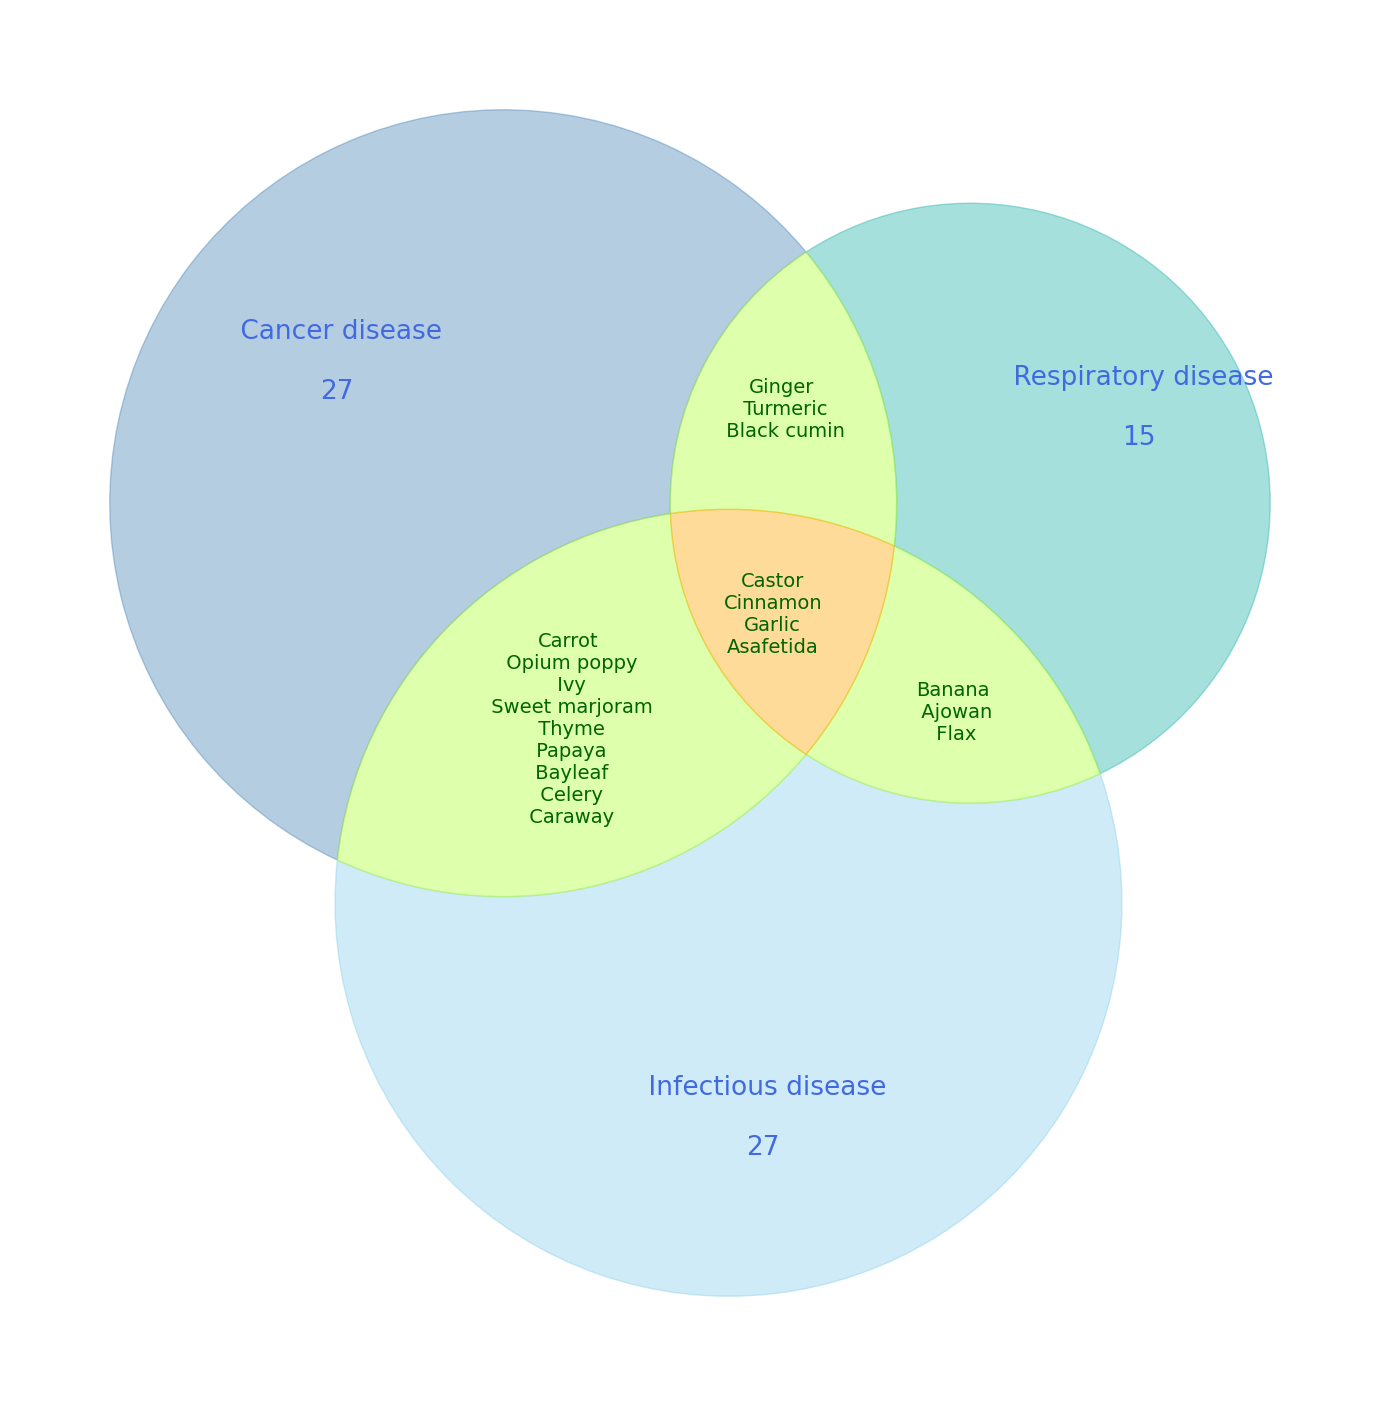

Selected groups for Venn diagram: ['cancer', 'respiratory', 'infectious']


In [15]:
import random
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

def plot_venn3(group2minsetdf, num_groups=3):
    """
    Create a Venn diagram for three disease groups
    
    Args:
        group2minsetdf: Dictionary containing DataFrames with spice information
        num_groups: Number of groups to include in Venn diagram (default 3)
    """
    # Get available groups from group2minsetdf
    available_groups = list(group2minsetdf.keys())
    
    # Randomly select 3 groups from available groups
    selected_groups = random.sample(available_groups, num_groups)
    
    setsize_dict = {}
    set_dict = {}
    minsets = []
    
    # Get spice sets for each selected group
    for group in selected_groups:
        minsets.append(set(group2minsetdf[group]['spices']))
    
    # Calculate set sizes and intersections
    set_dict['100'] = minsets[0]
    setsize_dict['100'] = len(set_dict['100'])
    set_dict['010'] = minsets[1]
    setsize_dict['010'] = len(set_dict['010'])
    set_dict['001'] = minsets[2]
    setsize_dict['001'] = len(set_dict['001'])
    
    # Calculate triple intersection
    set_dict['111'] = minsets[0].intersection(minsets[1]).intersection(minsets[2])
    if set_dict['111']:
        setsize_dict['111'] = len(set_dict['111'])
    
    # Calculate pair-wise intersections
    set_dict['110'] = minsets[0].intersection(minsets[1]) - set_dict['111']
    setsize_dict['110'] = len(set_dict['110'])
    set_dict['101'] = minsets[0].intersection(minsets[2]) - set_dict['111']
    setsize_dict['101'] = len(set_dict['101'])
    set_dict['011'] = minsets[1].intersection(minsets[2]) - set_dict['111']
    setsize_dict['011'] = len(set_dict['011'])
    
    print("Common spices across all three groups:", set_dict['111'])
    
    # Create Venn diagram
    plt.figure(figsize=(18, 18))
    v3 = venn3(subsets={k: v for k, v in setsize_dict.items() if v}, 
               set_labels=('', '', '', '', '', ''))
    
    # Set colors for different regions
    patch_ids = ['100', '010', '001', '110', '101', '011', '111']
    colors = ['steelblue', 'lightseagreen', 'skyblue', 'greenyellow', 
              'greenyellow', 'greenyellow', 'orange']
    
    for patch_id, color in zip(patch_ids, colors):
        patch = v3.get_patch_by_id(patch_id)
        if patch:
            patch.set_color(color)
    
    # Set labels for main sections
    for i, (patch_id, group) in enumerate([('100', selected_groups[0]), 
                                         ('010', selected_groups[1]), 
                                         ('001', selected_groups[2])]):
        label = v3.get_label_by_id(patch_id)
        if label:
            label.set_text(f' {group.capitalize()} disease\n\n{setsize_dict[patch_id]}')
    
    # Set labels for intersections
    for patch_id in ['110', '101', '011']:
        label = v3.get_label_by_id(patch_id)
        if label and set_dict[patch_id]:
            label.set_text('\n '.join(set_dict[patch_id]))
    
    if set_dict['111']:
        label = v3.get_label_by_id('111')
        if label:
            label.set_text('\n'.join(set_dict['111']))
    
    # Customize font sizes and colors
    for j, label in enumerate(v3.subset_labels):
        if label:
            if j in [2, 6, 4, 5]:
                try:
                    label.set_fontsize(14)
                    label.set_color('darkgreen')
                except:
                    continue
            else:
                label.set_fontsize(19)
                label.set_color('royalblue')
    
    # Save and show the plot
    plt.savefig(f'venn3_{"_".join(selected_groups)}.png', bbox_inches='tight', dpi=300)
    plt.show()
    
    return selected_groups

# Usage
selected_groups = plot_venn3(group2minsetdf)
print("Selected groups for Venn diagram:", selected_groups)